In [1]:
import torch
import numpy as np
import os
os.chdir('..')

import torch_converter as tc
import instance_generator as ig
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from util import NumpyDataset, Dataset
from evaluate import evaluate_model, pp_output
import evaluate as ev
from gnn_library.OBM_greedy import OBM_Greedy
#import evaluate as ev

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 1.12.0+cu102
Using device: cuda:2


In [3]:
GNN1, args1 = load('GNN1', device)
GNN2, args2 = load('GNN2', device)
GNN3, args3 = load('GNN3', device)
GREEDY = OBM_Greedy()

FileNotFoundError: [Errno 2] No such file or directory: './trained_models/GNN3_args.pickle'

In [4]:
er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

avg_ratios = []
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for epsilon in epsilons:
    rng = np.random.default_rng()

    instances = [
        # *ig.sample_instances(6, 10, 100, rng, **er_config),
        # *ig.sample_instances(6, 10, 100, rng, **ba_config),
        # # *ig.sample_instances(6, 10, 100, rng, **geom_config),
        # *ig.sample_instances(8, 8, 100, rng, **er_config),
        # *ig.sample_instances(8, 8, 100, rng, **ba_config),
        # *ig.sample_instances(8, 8, 100, rng, **geom_config),
        *ig.sample_instances(10, 6, 100, rng, **er_config),
        *ig.sample_instances(10, 6, 100, rng, **ba_config),
        *ig.sample_instances(10, 6, 100, rng, **geom_config)
    ]

    ratios = ev.evaluate_shakey_opt(
        epsilon=epsilon,
        base_models=[GNN1, GNN2, GREEDY],
        instances=instances,
        batch_size=50,
        rng=rng,
        num_realizations=10
    )

    avg_ratios.append(np.mean(ratios[0]).round(4))

    

KeyboardInterrupt: 

### I. Meta GNN training/evaluation

In [50]:
args = {
    'processor':         'TEST',
    'head':              'meta',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        12,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        3,
    'dropout':           0.25,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 25; test_num = 5

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, **ba_config),
    *ig.sample_instances(8, 8, train_num, rng, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, **ba_config),
    *ig.sample_instances(8, 8, test_num, rng, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, **geom_config)
]

train_data = Dataset(
    tc._instances_to_train_samples(
        instances=train_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GREEDY, GNN2]
    )
)

test_data = Dataset(
    tc._instances_to_train_samples(
        instances=test_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GREEDY, GNN2]
    )
)

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [57]:
args = {
    'processor':         'TEST',
    'head':              'meta',
    'num_layers':        2,
    'aggr':              'max',
    'batch_size':        12,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        1,
    'output_dim':        3,
    'dropout':           0,
    'epochs':            50,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.01,
    'device':            device
}

In [58]:
sum = torch.zeros(3)
for data in train_data:
    sum += data.hint

print(sum)

tensor([613., 512., 525.])


In [59]:
_, _, META_GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/50 [00:00<?, ?Epochs/s]

1.1000177166678689


Training:   2%|▏         | 1/50 [00:03<03:08,  3.84s/Epochs]

TEST ACCURACY: 0.41566264629364014
TEST LOSS: 1.0826165676116943


Training:   4%|▍         | 2/50 [00:06<02:43,  3.40s/Epochs]

1.0922668795152144
1.0894093764911998


Training:   6%|▌         | 3/50 [00:11<02:58,  3.80s/Epochs]

TEST ACCURACY: 0.3765060007572174
TEST LOSS: 1.0916435718536377


Training:   8%|▊         | 4/50 [00:14<02:39,  3.46s/Epochs]

1.090281869281422
1.0899225052920254


Training:  10%|█         | 5/50 [00:17<02:39,  3.54s/Epochs]

TEST ACCURACY: 0.3885542154312134
TEST LOSS: 1.0819172859191895


Training:  12%|█▏        | 6/50 [00:20<02:28,  3.37s/Epochs]

1.0901329209587791
1.0896850343184037


Training:  14%|█▍        | 7/50 [00:24<02:30,  3.49s/Epochs]

TEST ACCURACY: 0.3825300931930542
TEST LOSS: 1.0804014205932617


Training:  16%|█▌        | 8/50 [00:27<02:19,  3.33s/Epochs]

1.0895981333472513
1.0901567615162242


Training:  18%|█▊        | 9/50 [00:31<02:22,  3.48s/Epochs]

TEST ACCURACY: 0.3885542154312134
TEST LOSS: 1.0806037187576294


Training:  18%|█▊        | 9/50 [00:33<02:30,  3.68s/Epochs]


KeyboardInterrupt: 

In [4]:
args = {
    'processor':         'TEST2',
    'head':              'meta',
    'num_layers':        4,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        6,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        8,
    'output_dim':        2,
    'head_mlp_dim':      8,
    'dropout':           0,
    'epochs':            200,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0005,
    'device':            device
}

train_num = 100; test_num = 20

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}


rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, **ba_config),
    *ig.sample_instances(8, 8, 4*train_num, rng, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, **ba_config),
    *ig.sample_instances(8, 8, 4*test_num, rng, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, **geom_config)
]

train_data = Dataset(
    tc._instances_to_gnn_samples(
        instances=train_instances,
        head='classification',
        base_models=[GNN1, GNN2],
        batch_size=args['batch_size']
    )
)

test_data = Dataset(
    tc._instances_to_gnn_samples(
        instances=test_instances,
        head='classification',
        base_models=[GNN1, GNN2],
        batch_size=args['batch_size']
    )
)



(array([0]), array([12000]))
(array([0]), array([12000]))
(array([0]), array([2400]))
(array([0]), array([2400]))


In [5]:

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [6]:
_, _, META_GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/200 [00:00<?, ?Epochs/s]/home/alexhay/.local/lib/python3.10/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
Training:   0%|          | 0/200 [00:04<?, ?Epochs/s]


KeyboardInterrupt: 

In [41]:
save(META_GNN, args, 'META_GNN')

In [23]:
seed = np.random.randint(0, 500000)
(m, n) = (22, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 100, rng, **config)

rng = np.random.default_rng(seed)
ratios1 = evaluate_model(
    meta_model=META_GNN,
    meta_model_type='hybrid',
    base_models=[GNN1, GNN2],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=10
)

pp_output(ratios1, _, show_log=False)
print()
print()

rng = np.random.default_rng(seed)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN1],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=10
)

pp_output(ratios2, _, show_log=False)

print()
print()

rng = np.random.default_rng(seed)

ratios = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN2],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=10
)

pp_output(ratios, _, show_log=False)

(array([1]), array([1000]))
-- Competitive ratios --
GNN: 0.9553
Greedy: 0.929


(array([0]), array([1000]))
-- Competitive ratios --
GNN: 0.954
Greedy: 0.929


(array([0]), array([1000]))
-- Competitive ratios --
GNN: 0.9553
Greedy: 0.929


0.58
0.012898973642615292
0.014747112591981101


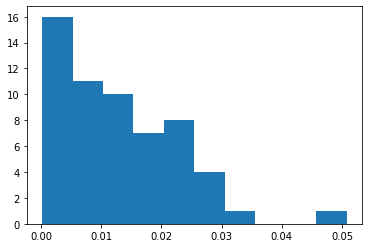

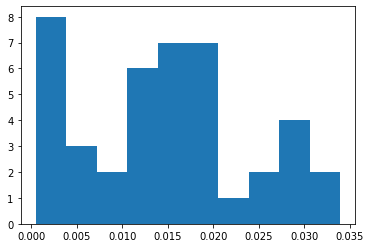

In [24]:
print(np.mean(ratios1[0] == np.max(np.vstack([ratios2[0], ratios[0]]), axis=0)))
eq_mask = ratios1[0] == np.max(np.vstack([ratios2[0], ratios[0]]), axis=0)
neq_mask = ratios1[0] != np.max(np.vstack([ratios2[0], ratios[0]]), axis=0)
diffs = np.abs(ratios2[0] - ratios[0])
print(np.mean(diffs[eq_mask]))
print(np.mean(diffs[neq_mask]))
import matplotlib.pyplot as plt
plt.hist(diffs[eq_mask])
plt.show()
plt.hist(diffs[neq_mask])
plt.show()

### II. Meta NN training

In [19]:
train_num = 50; test_num = 20

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

args = {
    'processor':         'NN',
    'head':              'meta',
    'num_layers':        5,
    'input_dim':         17,
    'batch_size':        4,
    'hidden_dim':        16,
    'output_dim':        2,
    'dropout':           0,
    'epochs':            50,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}


rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, **ba_config),
    *ig.sample_instances(8, 8, train_num, rng, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, **ba_config),
    *ig.sample_instances(8, 8, test_num, rng, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, **geom_config)
]

train_data = NumpyDataset(
    tc._instances_to_nn_samples(
        instances=train_instances,
        base_models=[GNN1, GNN2],
        batch_size=100
    )
)

test_data = NumpyDataset(
    tc._instances_to_nn_samples(
        instances=test_instances,
        base_models=[GNN1, GNN2],
        batch_size=100
    )
)



(array([0]), array([4500]))
(array([0]), array([4500]))
(array([0]), array([1800]))
(array([0]), array([1800]))


In [20]:
for i, sample in enumerate(train_data):
    assert not torch.all(sample[1] == 0)

In [21]:
args = {
    'processor':         'NN',
    'head':              'meta',
    'num_layers':        2,
    'input_dim':         23,
    'batch_size':        10,
    'hidden_dim':        8,
    'output_dim':        2,
    'dropout':           0,
    'epochs':            100,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.001,
    'device':            device
}

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

_, _, META_NN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/100 [00:00<?, ?Epochs/s]

0.7240231646431817


Training:   1%|          | 1/100 [00:02<03:18,  2.01s/Epochs]

TEST ACCURACY: 0.5055555701255798
TEST LOSS: 0.7236821055412292


Training:   2%|▏         | 2/100 [00:03<02:31,  1.55s/Epochs]

0.7229995939466688
0.7207862310939365


Training:   3%|▎         | 3/100 [00:05<02:42,  1.67s/Epochs]

TEST ACCURACY: 0.5611111521720886
TEST LOSS: 0.7178555130958557


Training:   4%|▍         | 4/100 [00:06<02:14,  1.40s/Epochs]

0.7162710653411017
0.7066686908404033


Training:   5%|▌         | 5/100 [00:07<02:32,  1.60s/Epochs]

TEST ACCURACY: 0.7666667103767395
TEST LOSS: 0.6972320079803467


Training:   6%|▌         | 6/100 [00:08<02:11,  1.40s/Epochs]

0.6877627783351474
0.6596528013547261


Training:   7%|▋         | 7/100 [00:10<02:22,  1.54s/Epochs]

TEST ACCURACY: 0.7666667103767395
TEST LOSS: 0.6468108296394348


Training:   8%|▊         | 8/100 [00:11<02:08,  1.39s/Epochs]

0.6371482584211562
0.6252259903483921


Training:   9%|▉         | 9/100 [00:13<02:23,  1.58s/Epochs]

TEST ACCURACY: 0.7666667103767395
TEST LOSS: 0.6252825856208801


Training:  10%|█         | 10/100 [00:15<02:11,  1.46s/Epochs]

0.6195137514008416
0.6166328059302436


Training:  11%|█         | 11/100 [00:16<02:18,  1.55s/Epochs]

TEST ACCURACY: 0.7666667103767395
TEST LOSS: 0.6204956769943237


Training:  12%|█▏        | 12/100 [00:18<02:07,  1.45s/Epochs]

0.6151777532365587
0.6136023839314778


Training:  13%|█▎        | 13/100 [00:20<02:22,  1.64s/Epochs]

TEST ACCURACY: 0.7666667103767395
TEST LOSS: 0.6174808740615845


Training:  14%|█▍        | 14/100 [00:21<02:07,  1.48s/Epochs]

0.6135880192120869
0.6112349377738104


Training:  15%|█▌        | 15/100 [00:23<02:14,  1.58s/Epochs]

TEST ACCURACY: 0.7666667103767395
TEST LOSS: 0.6139145493507385


Training:  16%|█▌        | 16/100 [00:24<01:57,  1.40s/Epochs]

0.6108887526724074
0.6086980925665961


Training:  17%|█▋        | 17/100 [00:25<02:08,  1.55s/Epochs]

TEST ACCURACY: 0.7666667103767395
TEST LOSS: 0.6107418537139893


Training:  18%|█▊        | 18/100 [00:26<01:54,  1.39s/Epochs]

0.6077464567290412
0.607272458076477


Training:  19%|█▉        | 19/100 [00:28<02:05,  1.55s/Epochs]

TEST ACCURACY: 0.7666667103767395
TEST LOSS: 0.6096671223640442


Training:  20%|██        | 20/100 [00:29<01:51,  1.40s/Epochs]

0.6037484380933974
0.6019725309477912


Training:  21%|██        | 21/100 [00:31<02:00,  1.53s/Epochs]

TEST ACCURACY: 0.7666667103767395
TEST LOSS: 0.6055665016174316


Training:  22%|██▏       | 22/100 [00:32<01:49,  1.40s/Epochs]

0.6015043444103665
0.6004575517442491


Training:  23%|██▎       | 23/100 [00:34<01:57,  1.53s/Epochs]

TEST ACCURACY: 0.7666667103767395
TEST LOSS: 0.6054508090019226


Training:  24%|██▍       | 24/100 [00:35<01:44,  1.37s/Epochs]

0.5986071878009372
0.5974701086680094


Training:  25%|██▌       | 25/100 [00:37<01:52,  1.50s/Epochs]

TEST ACCURACY: 0.7722222208976746
TEST LOSS: 0.6017482280731201


Training:  26%|██▌       | 26/100 [00:38<01:39,  1.35s/Epochs]

0.5961576329337226
0.5947402066654629


Training:  27%|██▋       | 27/100 [00:40<01:47,  1.48s/Epochs]

TEST ACCURACY: 0.8333333730697632
TEST LOSS: 0.5971508026123047


Training:  28%|██▊       | 28/100 [00:41<01:37,  1.36s/Epochs]

0.5953693151473999
0.5931732919481065


Training:  29%|██▉       | 29/100 [00:43<01:45,  1.48s/Epochs]

TEST ACCURACY: 0.8500000238418579
TEST LOSS: 0.5950509309768677


Training:  30%|███       | 30/100 [00:44<01:33,  1.34s/Epochs]

0.592371752527025
0.5915113661024306


Training:  31%|███       | 31/100 [00:46<01:45,  1.52s/Epochs]

TEST ACCURACY: 0.8500000238418579
TEST LOSS: 0.5939547419548035


Training:  32%|███▏      | 32/100 [00:47<01:34,  1.40s/Epochs]

0.5915683746337891
0.5915762212541368


Training:  33%|███▎      | 33/100 [00:49<01:47,  1.61s/Epochs]

TEST ACCURACY: 0.8388888835906982
TEST LOSS: 0.5943393707275391


Training:  34%|███▍      | 34/100 [00:50<01:34,  1.43s/Epochs]

0.5912882116105821
0.5904650939835443


Training:  35%|███▌      | 35/100 [00:52<01:40,  1.55s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5908098816871643


Training:  36%|███▌      | 36/100 [00:53<01:29,  1.40s/Epochs]

0.5896397908528646
0.5895846472846137


Training:  37%|███▋      | 37/100 [00:55<01:37,  1.55s/Epochs]

TEST ACCURACY: 0.8388888835906982
TEST LOSS: 0.5931867957115173


Training:  38%|███▊      | 38/100 [00:56<01:26,  1.39s/Epochs]

0.5890701333681743
0.5899629513422648


Training:  39%|███▉      | 39/100 [00:58<01:37,  1.60s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5891065001487732


Training:  40%|████      | 40/100 [00:59<01:26,  1.44s/Epochs]

0.5884655793507894
0.5880133522881402


Training:  41%|████      | 41/100 [01:01<01:31,  1.55s/Epochs]

TEST ACCURACY: 0.8500000238418579
TEST LOSS: 0.5915610790252686


Training:  42%|████▏     | 42/100 [01:02<01:22,  1.42s/Epochs]

0.5880140728420682
0.5883955134285821


Training:  43%|████▎     | 43/100 [01:04<01:30,  1.59s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5890679359436035


Training:  44%|████▍     | 44/100 [01:05<01:22,  1.47s/Epochs]

0.5870812243885464
0.5868281112776862


Training:  45%|████▌     | 45/100 [01:07<01:28,  1.61s/Epochs]

TEST ACCURACY: 0.8500000238418579
TEST LOSS: 0.5899171233177185


Training:  46%|████▌     | 46/100 [01:08<01:22,  1.52s/Epochs]

0.5868333564864264
0.5865554306242201


Training:  47%|████▋     | 47/100 [01:10<01:29,  1.68s/Epochs]

TEST ACCURACY: 0.8500000238418579
TEST LOSS: 0.589449405670166


Training:  48%|████▊     | 48/100 [01:11<01:18,  1.50s/Epochs]

0.5864328530099657
0.5862705720795526


Training:  49%|████▉     | 49/100 [01:13<01:23,  1.64s/Epochs]

TEST ACCURACY: 0.8500000238418579
TEST LOSS: 0.5891430974006653


Training:  50%|█████     | 50/100 [01:14<01:16,  1.53s/Epochs]

0.5864329059918721
0.5861235207981533


Training:  51%|█████     | 51/100 [01:16<01:21,  1.66s/Epochs]

TEST ACCURACY: 0.8500000238418579
TEST LOSS: 0.5905145406723022


Training:  52%|█████▏    | 52/100 [01:18<01:11,  1.49s/Epochs]

0.585779959625668
0.5852448980013529


Training:  53%|█████▎    | 53/100 [01:20<01:18,  1.67s/Epochs]

TEST ACCURACY: 0.8388888835906982
TEST LOSS: 0.5906965732574463


Training:  54%|█████▍    | 54/100 [01:21<01:10,  1.53s/Epochs]

0.5873327559894985
0.5863962199952867


Training:  55%|█████▌    | 55/100 [01:23<01:15,  1.67s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5881565809249878


Training:  56%|█████▌    | 56/100 [01:24<01:06,  1.52s/Epochs]

0.5856053286128574
0.5860694183243645


Training:  57%|█████▋    | 57/100 [01:26<01:09,  1.61s/Epochs]

TEST ACCURACY: 0.8500000238418579
TEST LOSS: 0.5892053246498108


Training:  58%|█████▊    | 58/100 [01:27<00:59,  1.42s/Epochs]

0.58610936138365
0.5861161735322741


Training:  59%|█████▉    | 59/100 [01:29<01:02,  1.54s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.586191713809967


Training:  60%|██████    | 60/100 [01:30<00:57,  1.43s/Epochs]

0.5852734631962246
0.5855674187342326


Training:  61%|██████    | 61/100 [01:32<00:59,  1.53s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5868799090385437


Training:  62%|██████▏   | 62/100 [01:33<00:52,  1.38s/Epochs]

0.5863774644003974
0.5852433575524224


Training:  63%|██████▎   | 63/100 [01:34<00:54,  1.47s/Epochs]

TEST ACCURACY: 0.8500000238418579
TEST LOSS: 0.5887928009033203


Training:  64%|██████▍   | 64/100 [01:35<00:48,  1.36s/Epochs]

0.5854157408078512
0.5856052782800463


Training:  65%|██████▌   | 65/100 [01:37<00:53,  1.53s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5877061486244202


Training:  66%|██████▌   | 66/100 [01:38<00:47,  1.40s/Epochs]

0.5863716959953308
0.5849883410665724


Training:  67%|██████▋   | 67/100 [01:40<00:51,  1.56s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5873951315879822


Training:  68%|██████▊   | 68/100 [01:41<00:45,  1.44s/Epochs]

0.5849463648266262
0.586500264538659


Training:  69%|██████▉   | 69/100 [01:43<00:48,  1.55s/Epochs]

TEST ACCURACY: 0.8500000238418579
TEST LOSS: 0.5886788368225098


Training:  70%|███████   | 70/100 [01:44<00:42,  1.40s/Epochs]

0.5853990501827664
0.5846787638134426


Training:  71%|███████   | 71/100 [01:46<00:45,  1.58s/Epochs]

TEST ACCURACY: 0.8500000238418579
TEST LOSS: 0.5882000923156738


Training:  72%|███████▏  | 72/100 [01:47<00:39,  1.43s/Epochs]

0.5847912523481581
0.5845696210861206


Training:  73%|███████▎  | 73/100 [01:49<00:44,  1.63s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5874817371368408


Training:  74%|███████▍  | 74/100 [01:51<00:38,  1.50s/Epochs]

0.5849866191546123
0.5854090319739448


Training:  75%|███████▌  | 75/100 [01:53<00:42,  1.70s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5866872668266296


Training:  76%|███████▌  | 76/100 [01:54<00:37,  1.55s/Epochs]

0.584751198026869
0.5848374909824795


Training:  77%|███████▋  | 77/100 [01:56<00:40,  1.75s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.586715042591095


Training:  78%|███████▊  | 78/100 [01:57<00:33,  1.54s/Epochs]

0.5851799011230469
0.5858289731873406


Training:  79%|███████▉  | 79/100 [01:59<00:35,  1.67s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.587546706199646


Training:  80%|████████  | 80/100 [02:00<00:30,  1.53s/Epochs]

0.5849842720561558
0.5850229157341851


Training:  81%|████████  | 81/100 [02:02<00:30,  1.60s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.587336540222168


Training:  82%|████████▏ | 82/100 [02:03<00:26,  1.46s/Epochs]

0.5844726032680936
0.5848672204547458


Training:  83%|████████▎ | 83/100 [02:05<00:27,  1.63s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5858814716339111


Training:  84%|████████▍ | 84/100 [02:07<00:23,  1.50s/Epochs]

0.5846951497925652
0.584676268365648


Training:  85%|████████▌ | 85/100 [02:08<00:23,  1.58s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5871620774269104


Training:  86%|████████▌ | 86/100 [02:09<00:19,  1.41s/Epochs]

0.5852156321207682
0.5850651794009738


Training:  87%|████████▋ | 87/100 [02:11<00:20,  1.54s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5874278545379639


Training:  88%|████████▊ | 88/100 [02:12<00:16,  1.37s/Epochs]

0.5843202643924289
0.584578111436632


Training:  89%|████████▉ | 89/100 [02:14<00:16,  1.49s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5861292481422424


Training:  90%|█████████ | 90/100 [02:15<00:13,  1.33s/Epochs]

0.5850567870669895
0.5854842291937934


Training:  91%|█████████ | 91/100 [02:17<00:13,  1.45s/Epochs]

TEST ACCURACY: 0.8555555939674377
TEST LOSS: 0.5864187479019165


Training:  92%|█████████▏| 92/100 [02:18<00:10,  1.30s/Epochs]

0.5844742549790276
0.584007469813029


Training:  93%|█████████▎| 93/100 [02:19<00:10,  1.46s/Epochs]

TEST ACCURACY: 0.8500000238418579
TEST LOSS: 0.5884774923324585


Training:  94%|█████████▍| 94/100 [02:21<00:08,  1.38s/Epochs]

0.5846079919073317
0.584686341550615


Training:  95%|█████████▌| 95/100 [02:23<00:07,  1.53s/Epochs]

TEST ACCURACY: 0.8500000238418579
TEST LOSS: 0.5876578092575073


Training:  96%|█████████▌| 96/100 [02:24<00:05,  1.41s/Epochs]

0.5852877484427558
0.5871835311253866


Training:  97%|█████████▋| 97/100 [02:26<00:04,  1.58s/Epochs]

TEST ACCURACY: 0.8444444537162781
TEST LOSS: 0.5894436836242676


Training:  98%|█████████▊| 98/100 [02:27<00:02,  1.45s/Epochs]

0.5846029427316454
0.585442578792572


Training:  99%|█████████▉| 99/100 [02:29<00:01,  1.61s/Epochs]

TEST ACCURACY: 0.8444444537162781
TEST LOSS: 0.5893855690956116


Training: 100%|██████████| 100/100 [02:30<00:00,  1.50s/Epochs]

0.5845045725504557


In [36]:
seed = np.random.randint(0, 50000)
(m, n) = (24, 16)
config = geom_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 250, rng, **config)

rng = np.random.default_rng(seed)
ratios1 = evaluate_model(
    meta_model=META_NN,
    meta_model_type='nn',
    base_models=[GNN1, GNN2],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios1, _, show_log=False)
print()
print()

rng = np.random.default_rng(seed)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN1],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios2, _, show_log=False)

print()
print()

rng = np.random.default_rng(seed)

ratios = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN2],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios, _, show_log=False)

(array([0, 1]), array([246,   4]))
-- Competitive ratios --
GNN: 0.9254
Greedy: 0.9208


(array([0]), array([1250]))
-- Competitive ratios --
GNN: 0.9254
Greedy: 0.9208


(array([0]), array([1250]))
-- Competitive ratios --
GNN: 0.9386
Greedy: 0.9208


0.432


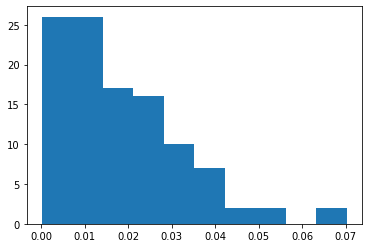

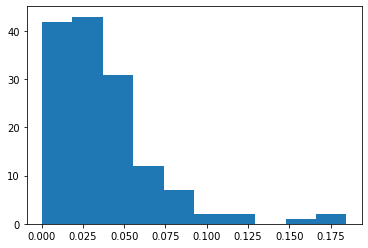

In [37]:
print(np.mean(ratios1[0] == np.max(np.vstack([ratios2[0], ratios[0]]), axis=0)))
eq_mask = ratios1[0] == np.max(np.vstack([ratios2[0], ratios[0]]), axis=0)
neq_mask = ratios1[0] != np.max(np.vstack([ratios2[0], ratios[0]]), axis=0)
diffs = np.abs(ratios2[0] - ratios[0])
import matplotlib.pyplot as plt
plt.hist(diffs[eq_mask])
plt.show()
plt.hist(diffs[neq_mask])
plt.show()

In [50]:
num_trials = 100
node_configs = [(x, 16) for x in np.arange(4, 64, 2)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
graph_configs = [
    # {
    #     'graph_type': 'GM'
    # },
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'threshold': 0.2,
        'scaling': 1 / np.sqrt(2),
    }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)
data = {config['graph_type']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)

        rng = np.random.default_rng(seed)
        (meta_learned_ratios, _) = evaluate_model(
            meta_model=META_GNN,
            meta_model_type='gnn',
            base_models=[GNN1, GNN2, GREEDY],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        rng = np.random.default_rng(seed)
        gnn1_learned_ratios, greedy_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN1],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        rng = np.random.default_rng(seed)
        gnn2_learned_ratios, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN2],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )


        data[graph_config['graph_type']].append(np.array(
            [
                meta_learned_ratios,
                gnn1_learned_ratios,
                gnn2_learned_ratios,
                greedy_ratios
            ]
        ))

[0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 1.375, 1.5, 1.625, 1.75, 1.875, 2.0, 2.125, 2.25, 2.375, 2.5, 2.625, 2.75, 2.875, 3.0, 3.125, 3.25, 3.375, 3.5, 3.625, 3.75, 3.875]
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (4, 16)
(array([1]), array([500]))
(array([0]), array([500]))
(array([0]), array([500]))
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (6, 16)
(array([1]), array([500]))
(array([0]), array([500]))
(array([0]), array([500]))
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (8, 16)
(array([1]), array([500]))
(array([0]), array([500]))
(array([0]), array([500]))
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (10, 16)
(array([1]), array([500]))
(array([0]), array([500]))
(array([0]), array([500]))
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (12, 16)
(array([1]), array([500]))
(array([0]), array([500]))
(array([0]), array([500]))
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (14, 16)
(array([1]), array([500]))
(array([0]), array([500]))
(

ER


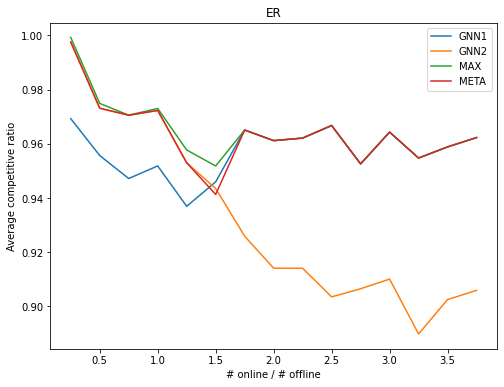

BA


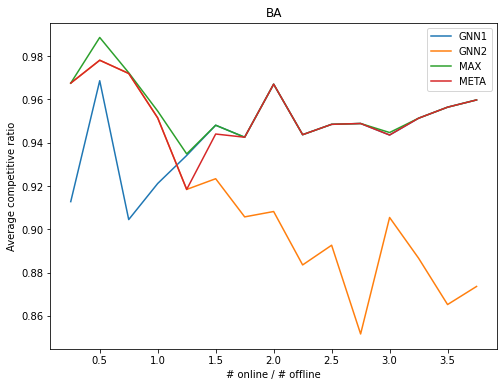

GEOM


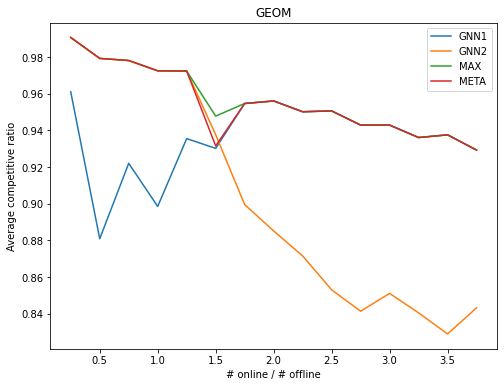

In [ ]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for graph_type, comp_ratios in data.items():
    greedy_avg_ratios = []
    meta_avg_ratios = []
    gnn1_avg_ratios = []
    gnn2_avg_ratios = []
    gnn3_avg_ratios = []
    max_avg_ratios = []

    for trial_ratios in comp_ratios:
        meta_avg_ratios.append(np.array(trial_ratios[0]).mean())
        gnn1_avg_ratios.append(np.array(trial_ratios[1]).mean())
        gnn2_avg_ratios.append(np.array(trial_ratios[2]).mean())
        #gnn3_avg_ratios.append(np.array(trial_ratios[3]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[3]).mean())
        max_avg_ratios.append(np.array(np.max(trial_ratios[1:3, :], axis=0)).mean())

    print(graph_type)
    fig = plt.figure(figsize=(8,6))
    plt.title(graph_type)
    plt.plot(ratios, gnn1_avg_ratios, label='GNN1')
    plt.plot(ratios, gnn2_avg_ratios, label='GNN2')
    #plt.plot(ratios, gnn3_avg_ratios, label='GNN3')
    #plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, max_avg_ratios, label='MAX')
    plt.plot(ratios, meta_avg_ratios, label='META')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.show()


In [ ]:
comp = np.vstack([gnn1_learned_ratios, gnn2_learned_ratios, greedy_ratios]).T
comp[:10]

In [ ]:
print(np.max(comp[:2, :], axis=1).mean())
print(comp.mean(axis=0))

In [ ]:
index1 = np.argmax(comp[:, 0] - comp[:, 1])
index2 = np.argmax(comp[:, 1] - comp[:, 0])

In [ ]:
tc._featurize(instances[index1])

In [ ]:
tc._featurize(instances[index2])

In [ ]:
GNN2_features = []
GNN1_features = []
for i, boolean in enumerate(comp[:, 1] > comp[:, 0]):
    if boolean:
        GNN2_features.append(tc._featurize(instances[i]))
    else:
        GNN1_features.append(tc._featurize(instances[i]))

out1 = np.vstack(GNN1_features)
out2 = np.vstack(GNN2_features)


In [ ]:
out1.mean(axis=0)

In [ ]:
out2.mean(axis=0)